# Model Comparison for Construction Cost Estimation

This notebook tests the dataset on various machine learning algorithms and selects the best model based on performance metrics.

In [51]:
# Import Required Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

In [67]:
# Load and Explore Dataset
data = pd.read_csv('realistic_construction_dataset.csv')

# Display the first few rows of the dataset
print(data.head())

# Check for missing values
print(data.isnull().sum())

# Summarize statistics
print(data.describe())

  building_type  area_sqm  floors  location foundation_type roof_type  \
0    Commercial     14814       5     Urban        Concrete      Flat   
1    Commercial     14598      13  Suburban            Slab      Flat   
2    Commercial      6078      11     Rural        Concrete   Pitched   
3    Commercial      6095      11     Urban            Slab      Flat   
4   Residential     14527      19     Urban        Concrete   Pitched   

   has_basement  has_parking  labor_rate  total_cost  
0             0            1       10400    50000000  
1             1            1       13100    50000000  
2             1            1       11400    50000000  
3             1            1        3000    50000000  
4             0            0        4100    50000000  
building_type      0
area_sqm           0
floors             0
location           0
foundation_type    0
roof_type          0
has_basement       0
has_parking        0
labor_rate         0
total_cost         0
dtype: int64
        

In [74]:
# Multiply total_cost by 10 (add an extra zero)
data['total_cost'] = data['total_cost'] * 10

print("Updated total_cost values (multiplied by 10):")
print(f"New cost range: ${data['total_cost'].min():,.0f} to ${data['total_cost'].max():,.0f}")
print(f"New average cost: ${data['total_cost'].mean():,.0f}")

# Display updated statistics
print("\nUpdated dataset statistics:")
print(data['total_cost'].describe())

Updated total_cost values (multiplied by 10):
New cost range: $13,983,290 to $500,000,000
New average cost: $453,026,328

Updated dataset statistics:
count    5.000000e+03
mean     4.530263e+08
std      1.120982e+08
min      1.398329e+07
25%      5.000000e+08
50%      5.000000e+08
75%      5.000000e+08
max      5.000000e+08
Name: total_cost, dtype: float64


In [75]:
# Preprocess Data
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Example preprocessing (adjust based on dataset)
numeric_features = data.drop(columns=['total_cost']).select_dtypes(include=['int64', 'float64']).columns
categorical_features = data.drop(columns=['total_cost']).select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Exclude the target column from the features
features = data.drop(columns=['total_cost'])
target = data['total_cost']

# Apply preprocessing to the features only
processed_data = preprocessor.fit_transform(features)

In [54]:
# View processed_data as a DataFrame
import pandas as pd

# Get feature names from preprocessor
numeric_column_names = numeric_features.tolist()
categorical_column_names = preprocessor.named_transformers_['cat'].get_feature_names_out().tolist()
column_names = numeric_column_names + categorical_column_names

processed_df = pd.DataFrame(processed_data, columns=column_names)
processed_df.head()

,area_sqm,floors,has_basement,has_parking,labor_rate,building_type_Commercial,building_type_Industrial,building_type_Residential,location_Rural,location_Suburban,location_Urban,foundation_type_Concrete,foundation_type_Pile,foundation_type_Slab,roof_type_Dome,roof_type_Flat,roof_type_Pitched
0,0.987455,0.210526,0.0,1.0,0.616667,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.972808,0.631579,1.0,1.0,0.841667,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.395063,0.526316,1.0,1.0,0.700000,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.396216,0.526316,1.0,1.0,0.000000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.967993,0.947368,0.0,0.0,0.091667,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


In [55]:
preprocessor

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,feature_range,"(0, ...)"
,copy,True
,clip,False


In [76]:
# Split Data into Train and Test Sets
# Ensure target is total_cost and features are all other columns
features = data.drop(columns=['total_cost'])
target = data['total_cost']

# Preprocess features only
processed_data = preprocessor.fit_transform(features)

X = processed_data  # Features
y = target.values   # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
import pandas as pd

# Adjust column names to match the shape of X
numeric_column_names = numeric_features.tolist()
categorical_column_names = preprocessor.named_transformers_['cat'].get_feature_names_out().tolist()

# Combine column names
column_names = numeric_column_names + categorical_column_names[:X.shape[1] - len(numeric_column_names)]

# Convert X to a DataFrame
X_df = pd.DataFrame(X, columns=column_names)

# Display the DataFrame
print(X_df.head())

   area_sqm    floors  has_basement  has_parking  labor_rate  \
0  0.987455  0.210526           0.0          1.0    0.616667   
1  0.972808  0.631579           1.0          1.0    0.841667   
2  0.395063  0.526316           1.0          1.0    0.700000   
3  0.396216  0.526316           1.0          1.0    0.000000   
4  0.967993  0.947368           0.0          0.0    0.091667   

   building_type_Commercial  building_type_Industrial  \
0                       1.0                       0.0   
1                       1.0                       0.0   
2                       1.0                       0.0   
3                       1.0                       0.0   
4                       0.0                       0.0   

   building_type_Residential  location_Rural  location_Suburban  \
0                        0.0             0.0                0.0   
1                        0.0             0.0                1.0   
2                        0.0             1.0                0.0   
3   

In [77]:
# Save the preprocessor
import joblib
joblib.dump(preprocessor, 'preprocessor.pkl')
print("Preprocessor saved as 'preprocessor.pkl'")

Preprocessor saved as 'preprocessor.pkl'


In [78]:
# Train and Evaluate Multiple ML Algorithms
from xgboost import XGBRegressor

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Support Vector Regressor': SVR(),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
}

results = []

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    results.append((name, r2, mae, rmse))
    print(f"{name} - R²: {r2:.4f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}")

Training Linear Regression...
Linear Regression - R²: 0.3580, MAE: 65355979.93, RMSE: 85447131.34
Training Random Forest...
Random Forest - R²: 0.9603, MAE: 7493689.78, RMSE: 21243262.02
Training Gradient Boosting...
Random Forest - R²: 0.9603, MAE: 7493689.78, RMSE: 21243262.02
Training Gradient Boosting...
Gradient Boosting - R²: 0.9493, MAE: 12183809.17, RMSE: 24017317.29
Training Support Vector Regressor...
Gradient Boosting - R²: 0.9493, MAE: 12183809.17, RMSE: 24017317.29
Training Support Vector Regressor...
Support Vector Regressor - R²: -0.1637, MAE: 43143468.23, RMSE: 115038225.23
Training XGBoost...
XGBoost - R²: 0.9507, MAE: 9513073.00, RMSE: 23687310.72
Support Vector Regressor - R²: -0.1637, MAE: 43143468.23, RMSE: 115038225.23
Training XGBoost...
XGBoost - R²: 0.9507, MAE: 9513073.00, RMSE: 23687310.72


                      Model        R²  Adjusted R²           MAE          RMSE
0         Linear Regression  0.357990     0.346876  6.535598e+07  8.544713e+07
1             Random Forest  0.960318     0.959631  7.493690e+06  2.124326e+07
2         Gradient Boosting  0.949278     0.948400  1.218381e+07  2.401732e+07
3  Support Vector Regressor -0.163673    -0.183818  4.314347e+07  1.150382e+08
4                   XGBoost  0.950662     0.949808  9.513073e+06  2.368731e+07


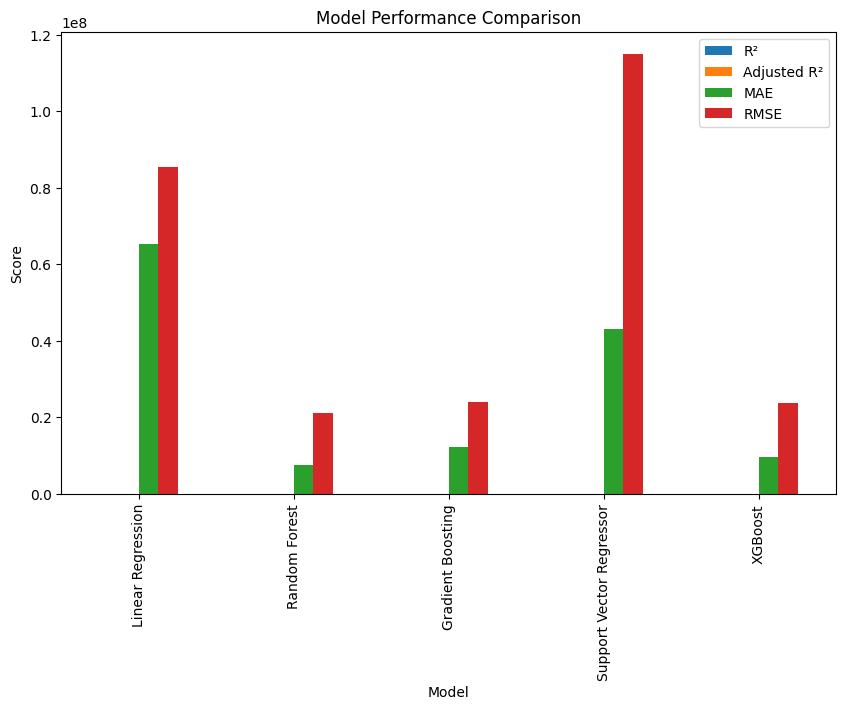

In [79]:
# Compare Model Performance
import pandas as pd

# Calculate adjusted R² for each model
n = len(y_test)  # number of samples
p = X_test.shape[1]  # number of features
adjusted_results = []

for name, r2, mae, rmse in results:
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    adjusted_results.append((name, r2, adjusted_r2, mae, rmse))

results_df = pd.DataFrame(adjusted_results, columns=['Model', 'R²', 'Adjusted R²', 'MAE', 'RMSE'])
print(results_df)

# Plot performance metrics (optional)
import matplotlib.pyplot as plt

results_df.set_index('Model')[['R²', 'Adjusted R²', 'MAE', 'RMSE']].plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.show()

In [80]:
# Select and Save the Best Model
best_model = max(results, key=lambda x: x[1])  # Select model with highest R²
print(f"Best Model: {best_model[0]} with R²: {best_model[1]:.4f}")

# Save the best model
final_model = models[best_model[0]]
joblib.dump(final_model, 'best_model.pkl')
print("Best model saved as 'best_model.pkl'")

Best Model: Random Forest with R²: 0.9603
Best model saved as 'best_model.pkl'


In [62]:
# Save the trained Linear Regression model
import joblib
joblib.dump(models['Linear Regression'], 'linear_model.pkl')
print("Linear Regression model saved as 'linear_model.pkl'")

Linear Regression model saved as 'linear_model.pkl'
